In [1]:
import numpy as np

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from plot_data import *
from data_loading import *

import json

from approaches.gaussian_predictor_levelsets import *
from approaches.gaussian_trainer import *


seed_everything(42)

In [2]:
seed_everything(42)

class RadiusTransformation2:
    def __init__(self, d, beta=None):
        if beta is None:
            beta = np.random.randn(d)
        self.beta = beta

    def get(self, x):
        return ((( np.linalg.norm(x)) / 2.0 + (np.dot(self.beta, x))**2 / 10) / 2 ) / .5 + 0.15
        return ( np.linalg.norm(x)) / 2.0 + np.exp(np.dot(self.beta, x))

d = 2
k = 2

input_dim = d
output_dim = k

tab_coverage = []
tab_warm_start_covariance_coverage = []
tab_warm_start_local_covariance_coverage = []
tab_hyper_rectangle_coverage = []

pert = "exponential"

n_train = 20_000
n_test = 1_000
n_calibration = 1_000
n_stop = 1_000
n_anchors = 10



config_name = "exp_t"

config_path = "../parameters/" + config_name + ".json"

with open(config_path, 'r') as file : 
    parameters = json.load(file)


dtype = torch.float32 if parameters["dtype"] == "float32" else torch.float64

alpha = 0.1

class NonLinearFunction2:
    def __init__(self, d, k, beta=None):
        if beta is None:
            beta = np.random.randn(d, k)
        self.beta = beta
        self.proj  = np.zeros((d, k))
        self.proj[0, 0] = 1.0
        self.proj[1, 1] = 1.0

    def get(self, x):
        nonlinear_term = np.sin(np.dot(x, self.beta)) + 0.5 * np.tanh(np.dot(x**2, self.beta)) + np.dot(x, self.proj)
        return nonlinear_term * 2

f_star = NonLinearFunction2(d, k)
radius = RadiusTransformation2(d)
local_perturbation = LocalPerturbation(d, k, n_anchors=n_anchors, radius_transformation=radius)
data_generator = DataGenerator(d, k, pert, f_star=f_star, local_perturbation=local_perturbation, covariance_matrix=np.array([[1.0, 0.5],[0.5, 1.0]]), bias = False, seed = 42)

x_train, y_train = data_generator.generate(n_train)
x_stop, y_stop = data_generator.generate(n_stop)
x_calibration, y_calibration = data_generator.generate(n_calibration)
x_test, y_test = data_generator.generate(n_test)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float32)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



In [3]:
seed_everything(42)

hidden_dim = 128
num_layers = 3
batch_size = 32
num_epochs = 300
lr = 1e-3

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size, shuffle=True)

gaussian_trainer = GaussianTrainer(input_dim, 
                            output_dim,
                            hidden_dim = hidden_dim,
                            num_layers = num_layers
                            )

gaussian_trainer.fit(trainloader, 
                    stoploader,
                    num_epochs=num_epochs,
                    lr=lr,
                    verbose = 2
                    )

center_model = gaussian_trainer.center_model
matrix_model = gaussian_trainer.matrix_model

gaussian_level_sets = GaussianPredictorLevelsets(center_model, matrix_model, dtype=dtype)

/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/approaches/gaussian_trainer.py:112: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2259.)
  z = torch.triangular_solve(diff, L, upper=False)[0]


Epoch 1: Avg NLL Loss = 0.8090 -- Stop loss: 0.4191 -- Best Stop Loss: inf
Epoch 2: Avg NLL Loss = 0.5437 -- Stop loss: 0.4965 -- Best Stop Loss: 0.4190719414036721
Epoch 3: Avg NLL Loss = 0.5014 -- Stop loss: 0.5002 -- Best Stop Loss: 0.4190719414036721
Epoch 4: Avg NLL Loss = 0.4862 -- Stop loss: 0.3664 -- Best Stop Loss: 0.4190719414036721
Epoch 5: Avg NLL Loss = 0.4705 -- Stop loss: 0.3596 -- Best Stop Loss: 0.3664152016863227
Epoch 6: Avg NLL Loss = 0.4587 -- Stop loss: 0.3342 -- Best Stop Loss: 0.3595520802773535
Epoch 7: Avg NLL Loss = 0.4661 -- Stop loss: 0.3455 -- Best Stop Loss: 0.3341538899112493
Epoch 8: Avg NLL Loss = 0.4507 -- Stop loss: 0.3673 -- Best Stop Loss: 0.3341538899112493
Epoch 9: Avg NLL Loss = 0.4452 -- Stop loss: 0.3770 -- Best Stop Loss: 0.3341538899112493
Epoch 10: Avg NLL Loss = 0.4349 -- Stop loss: 0.4020 -- Best Stop Loss: 0.3341538899112493
Epoch 11: Avg NLL Loss = 0.4321 -- Stop loss: 0.3078 -- Best Stop Loss: 0.3341538899112493
Epoch 12: Avg NLL Loss 

In [4]:
gaussian_level_sets.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)

tensor(2.0828)

In [5]:
idx_knowned = np.array([0])

gaussian_level_sets.conformalize_with_knowned_idx(x_calibration=x_calibration_tensor, 
                                            y_calibration=y_calibration_tensor, 
                                            alpha = alpha, 
                                            idx_knowned=idx_knowned)

tensor(1.3828)

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_25084/2168158813.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_25084/2168158813.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_25084/2168158813.py:41: UserWarning: *c* argument looks like a single numeric RGB or RG

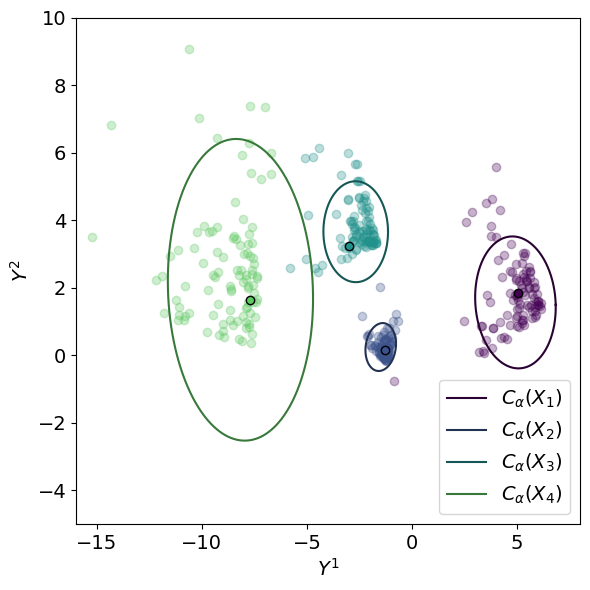

In [6]:
tab_seed = [0, 2, 56, 79]
q_val = 2.0
dtype = torch.float32

coverage_emp = []

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 

fig, ax = plt.subplots(figsize=(6, 6))


color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        if seed == 14:
                y_specific[0] = np.array([9.0, 0.0])

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        centers = gaussian_level_sets.get_centers(x_specific_tensor)
        centers_np = centers.detach().numpy()
        Lambdas_specific = gaussian_level_sets.get_Lambdas(x_specific_tensor)
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        radius = gaussian_level_sets.nu_conformal.item()

        ax = add_ellipse(ax,  centers_np[0], Lambdas_specific_np[0], q_val, radius, color = darker_viridis(i),  label=fr'$C_\alpha(X_{{{i+1}}})$')
          
        coverage_emp.append(gaussian_level_sets.get_coverage(x_specific_tensor, y_specific_tensor))
          
        ax.scatter(y_specific[:, 0], y_specific[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific[0, 0], y_specific[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        ax.set_xlabel(r'$Y^1$', fontsize=14)
        ax.set_ylabel(r'$Y^2$', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        ax.legend(fontsize=14, loc='lower right')

        ax.set_xlim(-16, 8)
        ax.set_ylim(-5, 10)


plt.tight_layout()

plt.savefig(f"../figs/{pert}_level_sets_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/{pert}_level_sets_{coverage_emp[0]:.2f}_{coverage_emp[1]:.2f}_{coverage_emp[2]:.2f}_{coverage_emp[3]:.2f}.pdf", dpi = 300, bbox_inches='tight')

plt.show()

plt.close()